# Introduction to the DEA Intertidal Product Suite <img align="right" src="../Supplementary_data/dea_logo.jpg">

The DEA Intertidal product suite is the next generation of DEA intertidal products that have been used across government and industry, helping to better characterise and understand the complex intertidal zone that is often defined as the interface between land and sea.   

Incorporating both Sentinel-2 and Landsat data, the product suite adds a temporal component to our elevation product for the intertidal zone, enabling users to better monitor and understand some of the most dynamic regions of Australia’s coastlines. With an improved tidal modelling capability, the product suite has been expanded to include a continental scale mapping of intertidal exposure over time, enabling scientists and managers to integrate the data into ecological and migratory species applications and modelling.  

## Background

The DEA Intertidal product suite is the next generation of intertidal products developed in DEA, leveraging our approach of combining time-series earth observation data with tidal modelling to create continental scale products for the intertidal region. The Intertidal Suite improves on the DEA Intertidal Elevation Model (also known as the [National Intertidal Digital Elevation Model or NIDEM](https://knowledge.dea.ga.gov.au/data/product/dea-intertidal-elevation-landsat) ) and adds several new features and products to help users better understand the intertidal environment and interpret the data.  

NIDEM was the first 3D model of Australia’s intertidal zone - the area of coastline exposed and flooded by ocean tides. The DEA Intertidal Suite fundamentally changes and improves the way in which we model the intertidal zone when compared to the original NIDEM elevation model and includes:  
- The addition of Sentinel-2 data improves the spatial resolution of the model to 10 m, compared to the 25 m of the original NIDEM.  
- Incorporation of a new pixel-based method supports a reduction in the temporal epoch of the product to 3 years (in comparison to 28 years in NIDEM), improving the ability to capture the current state of dynamic coastal environments, and enabling change-over-time applications using annual epochs.  
- Quantification of the vertical uncertainty of the elevation model.  
- An Intertidal Exposure model at 10 m resolution to examine the spatiotemporal patterns of exposure and inundation across the intertidal zone, supporting migratory species studies and habitat mapping applications.  
- A coastal extents classification model that identifies six categorical classes to compliment the Elevation and Exposure products, and help users better characterise different environments in the coastal zone in terms of their inundation characteristics and drivers, mapping confidence and nature of water cover. 
- Tidal metrics to enable users to understand the varied ranges and distributions of tidal stages observed by the Landsat and Sentinel-2 satellites across Australia, and how this information can be used to better understand and interpret the products.  
- The implementation of an ensemble tidal modelling approach, acknowledging the wide range of global and regional tide models available and their varying performance across different regions of Australia (see Ensemble Tidal Modelling).

## Description

This notebook introduces the Digital Earth Australia (DEA) Intertidal Product Suite.
All datasets are produced by DEA and are accessible in the DEA product archive.
In addition to access here in the DEA Sandbox, they can also be explored via [DEA Maps](https://maps.dea.ga.gov.au/) and are available directly via [DEA Explorer](https://explorer.dea.ga.gov.au/).
See the [DEA Knowledge Hub product description](https://knowledge.dea.ga.gov.au/data/theme/sea-ocean-and-coast/) for further information, including a complete review of the methods employed in the generation of datasets in this product suite.

In this notebook, users will:
- learn about the datasets and how they are inter-related
- interact with datasets including how to load your own area-of-interest, visualise, interpret and export data in GIS-ready formats
- explore basic use cases

By the end of this notebook, users should have an understanding of what these datasets are, how they can be used, their limitations and what the fixed parameters are.
To begin customising these parameters, such as time-period and exposure options, users can explore *this (future) notebook*.

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [69]:
# %matplotlib inline

import datacube
import cmocean
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from IPython.core.display import Video
from ipywidgets import Output, GridspecLayout

import odc.geo.xr
from datacube.utils.masking import mask_invalid_data
from dea_tools.plotting import display_map, xr_animation,rgb


In [2]:
## Temp cell for prototyping: load data from dev database

# Identify your area of interest as EPSG:4326 coordinates
# Identify your time period of interest as start and end dates



config = {
    'db_hostname': 'dea-dev-eks-proxy-share.endpoint.proxy-cxhoeczwhtar.ap-southeast-2.rds.amazonaws.com',
    'db_database': 'odc',
    'db_username': 'sandbox_reader',
    'db_password': 'ZWGRrBLmRs9WqTIj'
}

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(config=config)

### Analysis parameters

In [4]:
# Port Canarvon, WA
query_params = dict(y=( -24.89068, -24.90967),
                    x=(113.63545, 113.64924),
                    time=("2016", "2023"))

# Burdekin region
# query_params = dict(y=( -19.60613, -19.65409),
#                     x=(147.56629, 147.59966),
#                     time=("2015", "2022"))

# Bowling Green Bay Spit
# query_params = dict(y=( -19.29613, -19.36813),
#                     x=(147.37158, 147.45790),
#                     time=("2015", "2022"))

# Point Stuart, NT
# query_params = dict(y=( -12.20498, -12.25596),
#                     x=(131.80951, 131.93608),
#                     time=("2015", "2022"))

# Calvert River, NT
# query_params = dict(y=( -16.21294, -16.28428),
#                     x=(137.68083, 137.76924),
#                     time=("2015", "2022"))

In [5]:
# View the area of interest over a generic basemap
display_map(x=query_params['x'], y=query_params['y'])

## Available products and measurements

The DEA Intertidal product suite contains four (4) core datasets, seven (7) tidal attribute (ta) layers, and two (2) quality assessment (qa) layers, all available as continental 10 m resolution GeoTIFFs for the Australian coastal and intertidal region.  

All datasets are produced annually from a three-year composite of input data from the combined Sentinel 2 and Landsat 7, 8 and 9 DEA Collection 3 surface reflectance products. The product time series commences from 2017, with datasets labelled by the middle year of data (e.g. the 2017 layer combines data from 2016, 2017 and 2018). Updates to the product suite are scheduled annually.

### List Products

Inspect the intertidal dataset in the DEA database

In [6]:
product = 'ga_s2ls_intertidal_cyear_3'
products = dc.list_products()
products.loc[product]

name                                         ga_s2ls_intertidal_cyear_3
description           Geoscience Australia Sentinel-2 Landsat Intert...
license                                                       CC-BY-4.0
default_crs                                                        None
default_resolution                                                 None
Name: ga_s2ls_intertidal_cyear_3, dtype: object

### List Measurements

Inspect the measurements and data properties available in the DEA Intertidal dataset

In [7]:
measurements = dc.list_measurements()
measurements.loc[product]

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
elevation,elevation,float32,metres above MSL,NaN,NaN,NaN
elevation_uncertainty,elevation_uncertainty,float32,metres,NaN,[uncertainty],NaN
exposure,exposure,uint8,percent,255,NaN,NaN
extents,extents,uint8,class,255,NaN,"{'extents': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],..."
ta_hat,ta_hat,float32,metres above MSL,NaN,[hat],NaN
ta_hot,ta_hot,float32,metres above MSL,NaN,[hot],NaN
ta_lot,ta_lot,float32,metres above MSL,NaN,[lot],NaN
ta_lat,ta_lat,float32,metres above MSL,NaN,[lat],NaN
ta_offset_high,ta_offset_high,uint8,percent,255,[offset_high],NaN


## Load data

Users need to be able to DIY their own areas and then be able to export to COG in this workflow.

In [8]:
# ## Temporary - load from COGs stored locally. Replace with indexed workflow down the track.

# geotiff_path = '../../data/interim/Groote_Eylandt_Feb2024/x99y124/2021-2023/x99y124_2021_2023_'

# file_path = 'elevation.tif'

# # Load the first dataset to establish the dimensions on the master 'intertidal' ds
# da = rioxarray.open_rasterio(geotiff_path + file_path)
# ds = da.to_dataset('band')
# ds = ds.rename({1:'elevation'})
# intertidal = ds.copy(deep=True)

# layer_names = ['oa_offset_hightide',
#                'oa_offset_lowtide',
#                'oa_spread',
#                'oa_hot',
#                'oa_lot',
#                'oa_hat',
#                'oa_lat',
#                'exposure_unfiltered',
#                'extents',
#                'elevation_uncertainty'
#               ]

# # Loop through and add the files of interest to the master ds
# for file in layer_names:
#     da = rioxarray.open_rasterio(geotiff_path + file + '.tif')
#     ds = da.to_dataset('band')
#     ds = ds.rename({1:file})
#     intertidal[str(file)] = ds[str(file)]

# # Inspect the master dataset
# intertidal


In [9]:
# Load the DEA Intertidal data suite for the area of interest
load_params = dict(
    dask_chunks={}
                  )

ds = dc.load(product="ga_s2ls_intertidal_cyear_3",
             **query_params,
             **load_params)


ds = mask_invalid_data(ds)
ds.load()

# Additionally, load the median annual Landsat imagery for the area of interest
geoMAD = dc.load(product='ga_ls8cls9c_gm_cyear_3', like=ds)#, time=query_params['time'])
geoMAD

# Inspect the DEA Intertidal dataset
ds

<xarray.Dataset>
Dimensions:                (time: 7, y: 232, x: 167)
Coordinates:
  * time                   (time) datetime64[ns] 2016-07-01T23:59:59.999999 ....
  * y                      (y) float64 -2.822e+06 -2.822e+06 ... -2.824e+06
  * x                      (x) float64 -1.828e+06 -1.828e+06 ... -1.827e+06
    spatial_ref            int32 3577
Data variables: (12/13)
    elevation              (time, y, x) float32 nan nan nan nan ... nan nan nan
    elevation_uncertainty  (time, y, x) float32 nan nan nan nan ... nan nan nan
    exposure               (time, y, x) float32 nan nan nan nan ... nan nan nan
    extents                (time, y, x) float32 0.0 0.0 0.0 0.0 ... 3.0 3.0 3.0
    ta_hat                 (time, y, x) float32 nan nan nan ... 0.8385 0.8385
    ta_hot                 (time, y, x) float32 nan nan nan ... 0.7703 0.7703
    ...                     ...
    ta_lat                 (time, y, x) float32 nan nan nan ... -0.9207 -0.9207
    ta_offset_high         (time, y, x) float32 nan nan nan nan ... 3.0 3.0 3.0
    ta_offset_low          (time, y, x) float32 nan nan nan ... 13.0 13.0 13.0
    ta_spread              (time, y, x) float32 nan nan nan ... 82.0 82.0 82.0
    qa_ndwi_corr           (time, y, x) float32 nan nan nan nan ... nan nan nan
    qa_ndwi_freq           (time, y, x) float32 0.0 0.0 0.0 ... 99.0 99.0 99.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Defining the Intertidal Zone - TODO

Plan: demonstrate how we have defined the intertidal zone using the wetness frequency and tide model correlation (and how users can access these?)

## Intertidal Elevation and Uncertainty

### Description

DEA Intertidal Elevation provides elevation in metre units relative to modelled Mean Sea Level for each pixel of the satellite-observed exposed intertidal zone across the Australian coastline.
The elevation model is generated from DEA Landsat and Sentinel-2 data surface reflectance from each three-year composite period, utilising a pixel-based approach based on Ensemble Tidal Modelling. 
For every pixel, the time-series of surface reflectance data is converted to the Normalised Difference Water Index (NDWI), and each observation tagged with the tidal height modelled at the time of acquisition by the satellite. 
A rolling median is applied from low to high tide to reduce noise (e.g. white water, sunglint, non-tidal water level variability), then analysed to identify the tide height at which the pixel transitions from dry to wet. This tide height represents the elevation of the pixel. 

The companion dataset, DEA Intertidal Elevation Uncertainty, provides a measure of the quality of each modelled elevation value in metre units. 
Uncertainty is calculated by assessing how cleanly the modelled elevation separates satellite observations into dry and wet observations. 
This is achieved by identifying satellite observations that were misclassified by the modelled elevation (e.g. pixels that were observed as wet at tide heights lower than the modelled elevation or observed dry at higher tide heights). 
The spread of the tide heights of these misclassified points are then summarised using a robust Median Absolute Deviation statistic. 
Common causes of high elevation uncertainty can be poor tidal model performance, rapidly changing intertidal morphology, or noisy underlying satellite data.  

### Plot and View

In [10]:
# Inspect the elevation and uncertainty data for the first timestep (2016)
ds[['elevation','elevation_uncertainty']].isel(time=0)

<xarray.Dataset>
Dimensions:                (y: 232, x: 167)
Coordinates:
    time                   datetime64[ns] 2016-07-01T23:59:59.999999
  * y                      (y) float64 -2.822e+06 -2.822e+06 ... -2.824e+06
  * x                      (x) float64 -1.828e+06 -1.828e+06 ... -1.827e+06
    spatial_ref            int32 3577
Data variables:
    elevation              (y, x) float32 nan nan nan nan ... nan nan nan nan
    elevation_uncertainty  (y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

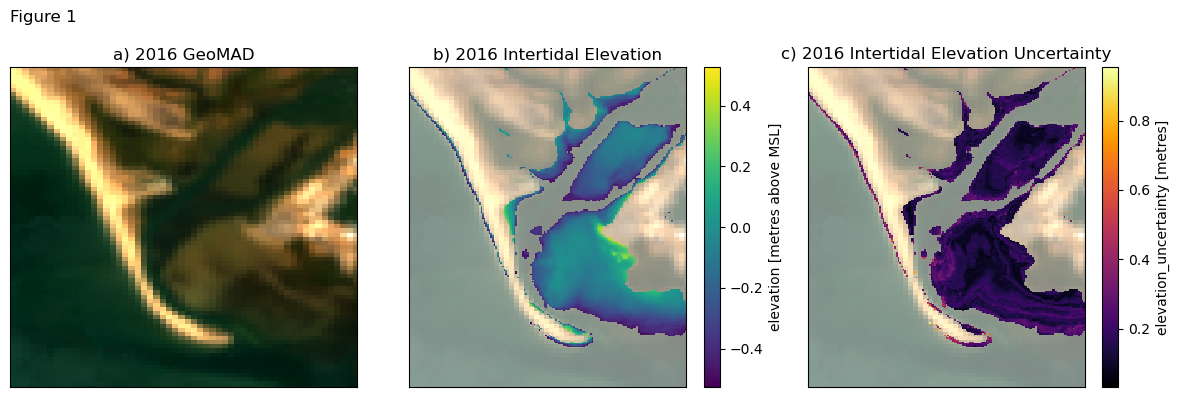

In [11]:
# Plot the intertidal elevation and uncertainty for the first timestep

# Setup the figure
fig, ax = plt.subplots(ncols=3, figsize=(12,4))

# Assign the datasets to the figure
rgb(geoMAD.isel(time=0), bands=['nbart_red','nbart_green','nbart_blue'],ax=ax[0])
rgb(geoMAD.isel(time=0), bands=['nbart_red','nbart_green','nbart_blue'],ax=ax[1], alpha=0.5)
ds.elevation.isel(time=0).plot(ax=ax[1], cmap='viridis')
rgb(geoMAD.isel(time=0), bands=['nbart_red','nbart_green','nbart_blue'],ax=ax[2], alpha=0.5)
ds.elevation_uncertainty.isel(time=0).plot(ax=ax[2], cmap='inferno')

# Tidy up the axes
ax[0].tick_params(labelbottom=False, labelleft=False, left=False,bottom=False)
ax[1].tick_params(labelbottom=False, labelleft=False, left=False,bottom=False)
ax[2].tick_params(labelbottom=False, labelleft=False, left=False,bottom=False)

ax[0].set(xlabel=None, ylabel=None)
ax[1].set(xlabel=None, ylabel=None)
ax[2].set(xlabel=None, ylabel=None)

# Label the figure plots
ax[0].set_title('a) 2016 GeoMAD')
ax[1].set_title('b) 2016 Intertidal Elevation')
ax[2].set_title('c) 2016 Intertidal Elevation Uncertainty')
fig.suptitle('Figure 1', x=0.04)

plt.tight_layout()

### Interpretation

Figure 1a (2016 GeoMAD) shows the median appearance of the location of interest during the time period of interest.
Note though that tidal position is *not* factored into this image and is used here to provide context to the DEA Intertidal results only.

Figure 1b shows the intertidal elevation at this location for the period 2015 to 2017 and is labelled as 2016. 
The spatial footprint of the intertidal area includes only pixels that are identified as intertidal with a high level of confidence (see the [Extents section](#Intertidal-Extents) for further discussion).
Users of this data should also be aware that there is a satellite-observed bias in many locations against detection of the full astronomical tidal range by orbiting satellites such as Landsat and Sentinel-2.
The bias is introduced by regular daily satellite overpass times that fail to overlap with the timing of tides in the upper or lower tidal range.
Consequently, any satellite-derived intertidal dataset may be subject to incomplete mapping of the full tidal range. 
We have mapped the extent of these tidal biases and provide a relative measure of how completely our satellite-observed datasets observe the full astronomical tidal range.
For further discussion, see the [Tidal Observation Attributes section](#Tidal-Observation-Attributes).

Figure 1c shows the vertical uncertainty of the elevation measurements. Patterns in the uncertainty dataset reflect the relative stability of the pixel during the epoch with dynamic areas producing greater uncertainty values compared to stable sites.
Other patterns in the uncertainty data reflect the input image quality and quantity as well as the quality of the tidal modelling for any given location.

The elevation and uncertainty measurements are both reported in metres above sea level.

## Intertidal Exposure

### Description

DEA Intertidal Exposure models the relative amount of time that any intertidal pixel is exposed from water coverage. Exposure is calculated by comparing the pixel elevation back against a high temporal resolution model of tide heights for that location, based on the Ensemble Tidal Modelling approach. The Exposure dataset reflects the percentage of time any given pixel, of known elevation, is exposed from tidal inundation, calculated as the fraction of exposed  observations relative to the total number of observations generated in the high temporal resolution tidal model for the three-year product epoch.   

### Plot and View

In [12]:
# Inspect the exposure data for the first timestep (2016)
ds['exposure'].isel(time=0)

<xarray.DataArray 'exposure' (y: 232, x: 167)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time         datetime64[ns] 2016-07-01T23:59:59.999999
  * y            (y) float64 -2.822e+06 -2.822e+06 ... -2.824e+06 -2.824e+06
  * x            (x) float64 -1.828e+06 -1.828e+06 ... -1.827e+06 -1.827e+06
    spatial_ref  int32 3577
Attributes:
    units:         percent
    nodata:        255
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

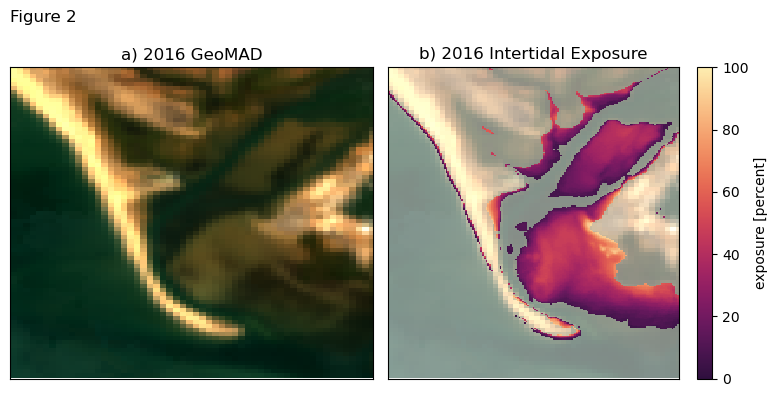

In [13]:
# Plot the intertidal exposure for the first timestep

# Setup the figure
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

# Assign the datasets to the figure
rgb(geoMAD.isel(time=0), bands=['nbart_red','nbart_green','nbart_blue'],ax=ax[0])
rgb(geoMAD.isel(time=0), bands=['nbart_red','nbart_green','nbart_blue'],ax=ax[1], alpha=0.5)
ds.exposure.isel(time=0).plot(ax=ax[1], cmap=cmocean.cm.matter_r, vmin=0, vmax=100)

# Tidy up the axes
ax[0].tick_params(labelbottom=False, labelleft=False, left=False,bottom=False)
ax[1].tick_params(labelbottom=False, labelleft=False, left=False,bottom=False)

ax[0].set(xlabel=None, ylabel=None)
ax[1].set(xlabel=None, ylabel=None)

# Label the figure plots
ax[0].set_title('a) 2016 GeoMAD')
ax[1].set_title('b) 2016 Intertidal Exposure')
fig.suptitle('Figure 2', x=0.06)

plt.tight_layout()

### Interpretation

Figure 2a (2016 GeoMAD) shows the median appearance of the location of interest during the time period of interest, as in Figure 1a, and is used to contextualise the results in 2b.

Figure 2b shows Intertidal Exposure for the area of interest during the period 2015-2017 (labelled 2016). 
The intertidal exposure values represent the relative amount of time that each pixel was exposed to the atmosphere, as a percentage of all time during the three year period of interest.

The spatial footprint of the intertidal area includes only pixels that are identified as intertidal with a high level of confidence (see the [Extents section](#Intertidal-Extents) for further discussion).
Although the relative distribution of values and patterns in the output Exposure dataset appears similar to the Intertidal Elevation, Intertidal Exposure values account for patterns and astronomical influences on the high-temporal tide model for the epoch at the location of interest.
These differences are usually most apparent at the highest and lowest ends of the modelled tide range and are influenced by factors including the tidal pattern of the location and lunar cycling.

Furthermore, depending on the location of interest, either or both of these extrema values may be absent from the Intertidal Exposure results dataset.
This data gap is caused by a satellite observed offset in image acquisition of the full astronomical tidal range across Australia which varies with both latitude and longitude.
We have mapped the extent of these tidal biases and provide a relative measure of how completely our satellite-observed datasets observe the full astronomical tidal range.
For further discussion, see the [Tidal Observation Attributes section](#Tidal-Observation-Attributes).

## Intertidal Extents

### Description

DEA Intertidal Extents is a categorical dataset classifying coastal areas into six classes, including the satellite-observed extents of the intertidal zone. This classification is based on DEA Intertidal Elevation outputs and other satellite-derived data including the inundation frequency of each pixel and correlations between inundation patterns and modelled tide heights. The "intensive urban" land use summary class of the [ABARES CLUM (Catchment-scale Land Use Map)](https://www.agriculture.gov.au/abares/aclump/catchment-scale-land-use-of-australia-update-december-2020) dataset was used to mask pixel misclassifications in urban areas. 

Coastal classes represented in the DEA Intertidal Extents dataset are as follows.
| Class Value | Class Label | Class Description |
| ------- | ------- | --------- |
| 0 | Dry | Pixels that are frequently detected as dry. This class also includes urban pixels that are misclassified as wet and intermittently wet pixels on the inland fringe of the intertidal zone that are close to the 'dry' threshold yet are uncorrelated to tide. |
| 1 | Inland intermittent wet | Pixels that are variably detected as wet through the time-series but are uncorrelated to tide and unconnected to the intertidal class. This class includes semi-permanent water bodies and water features whose connection to the intertidal class has changed during the time-series and includes intermittently closed and open lakes and lagoons (ICOLLs).  |
| 2 | Inland persistent wet  | Pixels that are frequently detected as wet and are unconnected to the intertidal class. This class will include coastal lakes and lagoons that were wet and unconnected to intertidal pixels for the entire time-series. |
| 3 | Tidal influenced persistent wet | Pixels that are frequently detected as wet and are connected to the intertidal class. This class also includes pixels that are variably detected as wet and are connected to the intertidal class, despite being uncorrelated to tide. This class typically includes the ocean and tide channels. |
| 4 | Intertidal low confidence | Pixels that are variably detected as wet and are correlated to tide yet do not have a valid elevation value. These pixels often fringe the intertidal zone and are likely to be intertidal but are considered low confidence due to possible misclassifications with sources of noise including sunglint, white water and poorly masked clouds. |
| 5 | Intertidal high confidence | Pixels that are variably detected as wet, are correlated with tide and have been assigned a valid elevation value. The pixels in this class match the extents of the DEA Elevation and DEA Exposure product footprints. |

### Plot and View 

In [14]:
# Inspect the data
ds.extents.isel(time=0)

<xarray.DataArray 'extents' (y: 232, x: 167)>
array([[0., 0., 0., ..., 3., 3., 3.],
       [0., 0., 0., ..., 3., 3., 3.],
       [0., 0., 0., ..., 3., 3., 3.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]], dtype=float32)
Coordinates:
    time         datetime64[ns] 2016-07-01T23:59:59.999999
  * y            (y) float64 -2.822e+06 -2.822e+06 ... -2.824e+06 -2.824e+06
  * x            (x) float64 -1.828e+06 -1.828e+06 ... -1.827e+06 -1.827e+06
    spatial_ref  int32 3577
Attributes:
    units:             class
    nodata:            255
    flags_definition:  {'extents': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'values...
    crs:               EPSG:3577
    grid_mapping:      spatial_ref

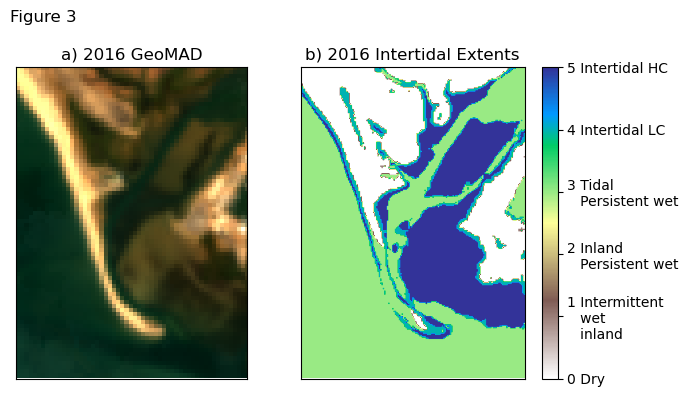

In [15]:
#Plot the data with labels for the first timestep

## Plot with labels
labels=['0 Dry',
       '1 Intermittent\n   wet\n   inland',
       '2 Inland\n   Persistent wet',
       '3 Tidal\n   Persistent wet',
       '4 Intertidal LC',
       '5 Intertidal HC',
       ]

fig,ax=plt.subplots(ncols=2,figsize=(7,4), width_ratios=[1,1.5]) #

rgb(geoMAD.isel(time=0), bands=['nbart_red','nbart_green','nbart_blue'],ax=ax[0])
cax=ax[1].imshow(ds['extents'].isel(time=0), cmap='terrain_r')
cbar=fig.colorbar(cax, ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(labels)

# Tidy up the axes
ax[0].tick_params(labelbottom=False, labelleft=False, left=False,bottom=False)
ax[1].tick_params(labelbottom=False, labelleft=False, left=False,bottom=False)

ax[0].set(xlabel=None, ylabel=None)
ax[1].set(xlabel=None, ylabel=None)

# Label the figure plots
ax[0].set_title('a) 2016 GeoMAD')
ax[1].set_title('b) 2016 Intertidal Extents')
fig.suptitle('Figure 3', x=0.06)

plt.tight_layout()

### Interpretation

Figure 3a (2016 GeoMAD) shows the median appearance of the location of interest during the time period of interest, as in Figure 1a, and is used to contextualise the results in 3b.

Figure 3b shows the categorical classification of the area of interest into Intertidal Extent classes.
Six land type classes are represented.
- The 'Intertidal HC' class represents pixels that are classified with a high level of confidence.
These pixels match the extent used to map the other intertidal data layers within the DEA Intertidal product suite.
- The 'Intertidal LC' class represents pixels that fringe the high confidence intertidal area and are probably intertidal pixels, though they are not associated with a valid modelled elevation in this workflow and are consequently classified as 'Low Confidence'.
- The 'Tidal Persistent Wet' class represents the ocean and permanently inundated tidal channels and estuaries.
- Two inland classes are represented and are differentiated by their inundation characteristics - one each are permanently and intermittently inundated.
  - 'Inland Persistent Wet' pixels represent coastal lakes and lagoons.
  - 'Inland Intermittent Wet' pixels typically represent coastal waterbodies that are not permanently inundated.
These include features such as intermittently closed and open lakes and lagoons (ICOLLs).
- The sixth class represents 'Dry' pixels which in this classifier, includes pixels with a very low detection rate for wetness.

## Tidal Attributes

The DEA Intertidal Tidal Attributes (ta) are a suite of datasets that describe the modelled (Astronomical) and satellite-observed (Observed) tidal attributes, as well as some satellite-sensor specific behaviours, that relate to every coastal pixel.
These datasets describe fundamental tidal characteristics for each pixel that both underpin the workflows included in the DEA Intertidal Product Suite, and are important to understand for complete interpretation of all satellite-derived intertidal datasets.

The DEA Intertidal Tidal Attributes are grouped into two categories: the highest and lowest Observed and Astronomical tides, and the satellite observed tidal offsets.

### Highest and Lowest Astronomical and Satellite-Observed Tides

Datasets of the highest and lowest astronomical and satellite-observed tide heights are foundational metadata that describe some satellite and tidal behaviours around the coastline.
These datasets are used to produce the following satellite-observed tidal offset datasets which are useful to understand how tide heights are mapped around the coastline and to interpret satellite-derived intertidal datasets.

In this work, the astronomical tide heights are considered to be the modelled tide heights, generated from the ensemble tidal modelling workflow.

#### Description

The following four datasets characterise Astronomical and Observed tides

| Variable name | Description |
| ---- | --- |
|ta_lot| The lowest observed tide dataset maps the lowest observed tide (LOT) of the satellite time-series at each pixel during the analysis epoch, based on ensemble tide modelling. |
|ta_hot| The highest observed tide dataset maps the highest observed tide (HOT) of the satellite time-series at each pixel during the analysis epoch, based on ensemble tide modelling. |
|ta_lat| The lowest astronomical tide dataset maps the lowest astronomical tide (LAT) for each pixel as modelled by the ensemble tide model for the analysis epoch. Note that the LAT modelled for the analysis epoch may differ from the LAT modelled across all-time for any given location. |
|ta_hat| The highest astronomical tide dataset maps the highest astronomical tide (HAT) for each pixel as modelled by the ensemble tide model for the analysis epoch. Note that the HAT modelled for the analysis epoch may differ from the HAT modelled across all-time for any given location. |

#### Plot and View

In [16]:
# Inspect the data for the first timestep (2016)
ds[['ta_lot','ta_hot', 'ta_lat','ta_hat']].isel(time=0)

<xarray.Dataset>
Dimensions:      (y: 232, x: 167)
Coordinates:
    time         datetime64[ns] 2016-07-01T23:59:59.999999
  * y            (y) float64 -2.822e+06 -2.822e+06 ... -2.824e+06 -2.824e+06
  * x            (x) float64 -1.828e+06 -1.828e+06 ... -1.827e+06 -1.827e+06
    spatial_ref  int32 3577
Data variables:
    ta_lot       (y, x) float32 nan nan nan nan ... -0.5703 -0.5703 -0.5703
    ta_hot       (y, x) float32 nan nan nan nan ... 0.7212 0.7212 0.7212 0.7212
    ta_lat       (y, x) float32 nan nan nan nan ... -0.8751 -0.8751 -0.8751
    ta_hat       (y, x) float32 nan nan nan nan ... 0.7929 0.7929 0.7929 0.7929
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

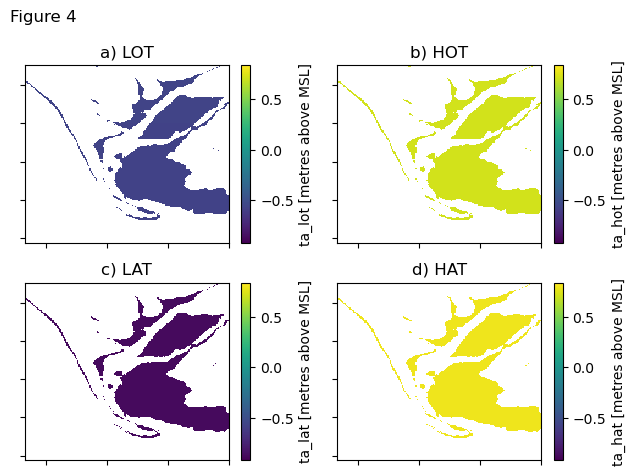

In [17]:
# Plot the data

# Identify the maxima and minima from the combined arrays to enable plotting them on a single color scale
minmax = np.array([ds.ta_lot.min(), 
                   ds.ta_lot.max(), 
                   ds.ta_lat.min(), 
                   ds.ta_lat.max(),
                   ds.ta_hot.min(), 
                   ds.ta_hot.max(), 
                   ds.ta_hat.min(), 
                   ds.ta_hat.max()])

# Prepare the figure
fig, axs = plt.subplots(2,2)

# Add the datasets to the figure
ds.ta_lot.isel(time=0).where(ds.elevation.isel(time=0).notnull()).plot(ax=axs[0,0], vmin=minmax.min(), vmax=minmax.max())
ds.ta_hot.isel(time=0).where(ds.elevation.isel(time=0).notnull()).plot(ax=axs[0,1], vmin=minmax.min(), vmax=minmax.max())
ds.ta_lat.isel(time=0).where(ds.elevation.isel(time=0).notnull()).plot(ax=axs[1,0], vmin=minmax.min(), vmax=minmax.max())
ds.ta_hat.isel(time=0).where(ds.elevation.isel(time=0).notnull()).plot(ax=axs[1,1], vmin=minmax.min(), vmax=minmax.max())

# Prepare the labels
axs[0,0].set_title('a) LOT')
axs[0,1].set_title('b) HOT')
axs[1,0].set_title('c) LAT')
axs[1,1].set_title('d) HAT')
fig.suptitle('Figure 4', x=0.06)

# Format the plot
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticklabels(labels='')
    ax.set_yticklabels(labels='')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()

#### Interpretation

Lowest and Highest Observed Tides (Figures 4 a-b) are calculated by attributing tide heights to all satellite imagery over a location for the accompanying date and time of image aquisition and then identifying the lowest observed height (LOT, Figure 4a) and the highest observed height (HOT, Figure 4b) from the imagery stack. 
Conversely, Lowest and Highest Astronomical Tides (Figures 4 c-d) represent minima and maxima elevations for any location, based on the global tide modelling used in this work.
Users should note though that due to our epoch-based approach, all LOT, HOT, LAT and HAT values also represent the epoch only and are not representative of all-time values. 
Oceanic pixels immediately adjacent to these intertidal regions follow the mapped intertidal trends.

This difference in absolute tide elevation values is attributed to the regular timing of astronomical influences on tide and overpass times of the Landsat and Sentinel-2 polar orbiting satellites.
Astronomical tide heights represent water elevations in oceanic and intertidal settings that are modelled, based on well characterised astronomical influences.
These influences typically relate to Earth and lunar orbits and their relative positions to one another, with gravitational affects from the moon most influential on local spatial scales at nighttime.
Note though that astronomical tidal modelling does not incorporate non-tidal influences such as sea-level rise and storm surge.
On the contrary, the overpass and image acquisition time of polar orbiting satellites is held constant to ensure maximum illumination with minimum atmospheric water vapor (haze and cloud build-up). 
The orbits of [Landsat 8 and Landsat 9](https://www.usgs.gov/faqs/what-are-acquisition-schedules-landsat-satellites) cross the equator at 10:00 a.m. mean local time during every overpass, with [Sentinel-2](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-2/satellite-description/orbit) scheduled for 10.30 a.m overpass times, locally.
The regularity of these overpass times introduces biases to the imaged range of tidal elevations for any given location.
Local geography and astronomical influences on tide modelling ensure that the full range of modelled tide elevations are rarely accounted for during these single satellite overpass times (Figure 5).

The comparison of Highest and Lowest Observed Tide heights (HOT/LOT) against the Highest and Lowest Astronomical Tides (HAT/LAT) enables identification of intertidal locations, at the pixel scale, where satellite observations of the tidal range are at odds with the modelled astronomical maxima/minima for the site.
These biases and offsets are quantified in further detail the following section.

### Satellite-Observed Tidal Offsets
Satellite-observed tidal offsets were introduced by [Bishop-Taylor et al (2019)](https://www.sciencedirect.com/science/article/pii/S0272771418308783) and describe the relative difference between the actual (astronomical) tide range with the satellite-observed tide-range at any location - in this case, any of Landsat 8, Landsat 9, Sentinel-2A or Sentinel-2B.
Due to the sun-synchronous, orbiting nature of these satellites, daily overpass (image aquisition) times are always approximately the same. 
This introduces a bias against complete imaging of the full tidal range in many locations (Figure 5).

![Figure 5](https://ars.els-cdn.com/content/image/1-s2.0-S0272771418308783-gr8.jpg) 
> **Figure 5** The distribution of Landsat observations relative to the full tidal range (after [Bishop-Taylor et al., 2019](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3)). Light colours in the left panels indicate poor coverage of the tidal range by Landsat: light colours in (a) indicate polygons where Landsat observed a small ‘spread’ calculated as a proportion of the full tidal range. Light colours in (b) and (c) represent polygons where Landsat observations were biased away from low or high tides respectively. For example, a polygon with a spread of 0.7, a high tide offset of 0.05 and a low tide offset of 0.25 indicates that Landsat observed 70% of the tidal range, but did not image the highest 5% or lowest 25% of tide heights. 

#### Description
The datasets included in this part of the DEA Intertidal Product Suite capture these satellite-tide characteristics, and include, for every coastal pixel, the:
| Variable name | Description |
| ---- | --- |
| ta_spread| The tidal spread dataset provides the percentage of the full astronomical tidal range observed by the time series of satellite observations at each pixel (see Figure 1a). DEA Intertidal Spread takes the concept of satellite tide bias, introduced in Bishop-Taylor et al (2019) and applies it at a pixel scale to demonstrate the fraction of the full tide range that was sensor observed during the analysis epoch at that location. In this work, we define the astronomical tide range as that modelled by the ensemble tide modelling approach. |
| ta_offset_low | The low tide offset dataset quantifies the proportion of the lowest tides never observed by satellites at each pixel (as a percentage of the astronomical tide range). It is calculated by measuring the offset between the lowest astronomical tide (LAT) and the lowest satellite-observed tide (LOT; see figure 1b). A high value indicates that DEA Intertidal datasets may not map the lowest regions of the intertidal zone.  |
| ta_offset_high | The high tide offset dataset quantifies the proportion of the highest tides never observed by satellites at each pixel (as a percentage of the astronomical tide range). It is calculated by measuring the offset between the highest astronomical tide (HAT) and the highest satellite-observed tide (HOT; see Figure 1c). A high value indicates that DEA Intertidal datasets may not map the highest regions of the intertidal zone. |

#### Plot and View

In [18]:
# Inspect the data for the first timestep (2016)
ds[['ta_offset_high','ta_offset_low', 'ta_spread']].isel(time=0)

<xarray.Dataset>
Dimensions:         (y: 232, x: 167)
Coordinates:
    time            datetime64[ns] 2016-07-01T23:59:59.999999
  * y               (y) float64 -2.822e+06 -2.822e+06 ... -2.824e+06 -2.824e+06
  * x               (x) float64 -1.828e+06 -1.828e+06 ... -1.827e+06 -1.827e+06
    spatial_ref     int32 3577
Data variables:
    ta_offset_high  (y, x) float32 nan nan nan nan nan ... 4.0 4.0 4.0 4.0 4.0
    ta_offset_low   (y, x) float32 nan nan nan nan nan ... 18.0 18.0 18.0 18.0
    ta_spread       (y, x) float32 nan nan nan nan nan ... 77.0 77.0 77.0 77.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

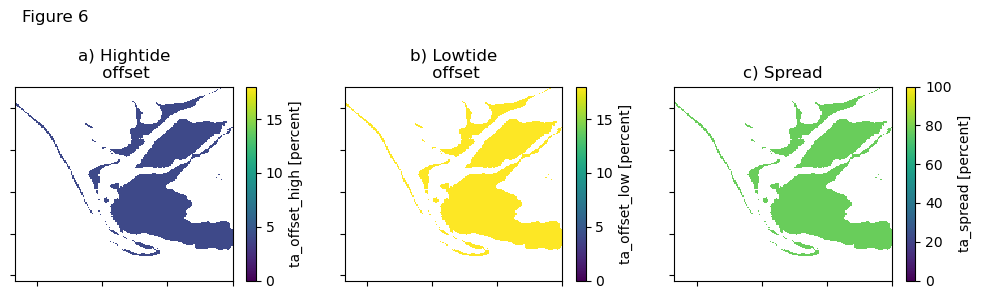

In [77]:
# Plot the data

# Identify the dataset maxima/minima to adjust the plot colourbar
minmax_offsets = np.array([ds.ta_offset_high.min(), 
                   ds.ta_offset_high.max(), 
                   ds.ta_offset_low.min(), 
                   ds.ta_offset_low.max()])

# Prepare the figure
fig, axs = plt.subplots(1,3, figsize=(10, 3))

# Add the datasets to the figure
ds.ta_offset_high.isel(time=0).where(ds.elevation.isel(time=0).notnull()).plot(ax=axs[0], vmin=0, vmax=minmax_offsets.max())
ds.ta_offset_low.isel(time=0).where(ds.elevation.isel(time=0).notnull()).plot(ax=axs[1], vmin=0, vmax=minmax_offsets.max())
ds.ta_spread.isel(time=0).where(ds.elevation.isel(time=0).notnull()).plot(ax=axs[2], vmin=0, vmax=100)

# Prepare the figure labels
axs[0].set_title('a) Hightide\n offset')
axs[1].set_title('b) Lowtide\n offset')
axs[2].set_title('c) Spread')
fig.suptitle('Figure 6', x=0.06)

# Format the plot
for ax in axs.flat:
    ax.set_xticklabels(labels='')
    ax.set_yticklabels(labels='')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()

#### Interpretation

Figure 6 represents a pixel based interpretation (10 m2) of [Figure 5](#Satellite-Observed-Tidal-Offsets) whereby the relative difference between modelled (Astronomical) and satellite-observed tide heights are quantified.

Figure 6a considers the hightide offset - the relative difference between the observed and astronomical hightide elevations.
An offset of 10 %, for example, indicates that the highest 10 % of astronomical tides are not observed by the satellite at this location, for the time period of interest.
The lower the value, the more closely the satellite-observed tides match the full astronomical tide range.

Similarly in Figure 6b, the lowest values represent the closest alignment of satellite-observed and astronomical tide heights.
A value of 15 % lowtide offset, for example, indicates that the satellite failed to image the location during the lowest 15 % of astronomically modelled tides.

These two concepts are bought together in the measure of spread (Figure 6c).
The tidal spread is an indicator of the range of tide heights observed for a given location, as a percentage of the full astronomical range, during the time period of interest.
A value of 80 % for example, indicates that most of the tide range was imaged by satellite.
However, it does not tell you how much of the satellite bias occurs at either end of the high and low tide range.

It is intended that these datasets be used to support the interpretation of satellite-derived intertidal datasets.
The methods employed in the DEA Intertidal product suite are applied to pixels that the algorithms determine as intertidal only and these pixels are derived exclusively from what the satellite has observed.
At the continental scale, it is envisioned that these tidal attribute datasets will support users to understand how comprehensively their areas of interest have been mapped and whether these datasets are suitable for their purposes.

Further exploration of these concepts can be found in the DEA Notebooks repository, available on the [DEA Sandbox](https://app.sandbox.dea.ga.gov.au ) for an interactive version, and for a static version, here in the [DEA Knowledge Hub](https://knowledge.dea.ga.gov.au/notebooks/How_to_guides/Tidal_modelling/#Evaluating-tidal-biases-using-tidal_stats).

# Use Case - Carnarvon Fascine 
## Siltation and Reclaimation works

DEA Intertidal product suite datasets have been used in the following example to support the identification of a [channel blockage and to monitor remediation works](https://www.transport.wa.gov.au/imarine/carnarvon-fascine-entryway-and-boat-harbour-pen-project.asp#:~:text=The%20Fascine%20is%20a%20waterway,a%20solution%20for%20Fascine%20access) undertaken by the Western Australian (WA) Department of Transport in Carnarvon, WA.

### Background

The Fascine is a waterway bordering the Carnarvon townsite and the Gascoyne River. It is one of the Carnarvon’s key assets, linking the community to the coast.
In 2017, the sand spit that protected the Fascine entrance and maintained the connection to the outer Teggs Channel breached due to wave action (Figure 7a).
This triggered excessive siltation of the Fascine entrance, closing the waterway to most vessels for several years, with minimum depths of less than half a metre at low tide.

Sand bars in the Fascine entrance and the channel alignment are constantly changing, further restricting access.
In June 2020, a plan was developed to rebuild and maintain a navigation channel to return Fascine connection to the coast for the local community.
A key challenge was accounting for rapid and ongoing changes in the Fascine entrance where a 150m change in the sandspit progression was identified between November 2020 and November 2021.

Dredging of the Carnarvon Fascine and Teggs Channel was planned (Figure 7b) to commenced in July 2023 and anticipated to be completed in early 2024.
Dredged material will be deposited on the Babbage Island Spit and used to reconstruct the natural dune system.

|Figure 7a | Figure 7b |
|- | - |
|<div>    <img src="https://www.transport.wa.gov.au/mediaFiles/projects/PROJ_I_Carnarvon_Siltation.jpg" width="1200">    </div> | <div> <img src = "https://www.transport.wa.gov.au/mediaFiles/projects/PROJ_I_Carnarvon_Fascine_Dredging_map.jpg" width="1500"> </div>|

#### View the breach
Plot and view the breaching sandbank and consequent infilling of the Fascine Channel. 
Compare the annual median view of the location against the changing annual intertidal elevation and intertidal elevation uncertainty for the area.

In [66]:
# Generate the time-series animations for the imagery, intertidal elevation and intertidal elevation uncertainty datasets

# Animate the imagery changes
xr_animation(ds=geoMAD,
             bands=['nbart_red','nbart_green','nbart_blue'],
             output_path='Carnarvon_Fascine_rgb_change_2016_to_2022.mp4',
             interval=1000,
             show_text='Figure 8a\n RGB'
            )
plt.close()

# Animate the elevation changes
xr_animation(ds=ds,
             bands=['elevation'],
             output_path='Carnarvon_Fascine_elevation_change_2016_to_2022.mp4',
             interval=1000,
             imshow_kwargs={'cmap':'viridis'},#,'vmin':float(ds.elevation.min()),'vmax':float(ds.elevation.max())},
             show_text='Figure 8b\n Elevation',
             # annotation_kwargs={'color':'black'}
             # show_colorbar=True
            )
plt.close()

# Animate the elevation uncertainty changes
xr_animation(ds=ds,
             bands=['elevation_uncertainty'],
             output_path='Carnarvon_Fascine_elevation_uncertainty_change_2016_to_2022.mp4',
             interval=1000,
             imshow_kwargs={'cmap':'inferno'},#,'vmin':float(ds.elevation_uncertainty.min()),'vmax':float(ds.elevation_uncertainty.max())}
             show_text='Figure 8c\n Uncertainty',
             # annotation_kwargs={'color':'black'}
            )
plt.close()


Exporting animation to Carnarvon_Fascine_rgb_change_2016_to_2022.mp4


  0%|          | 0/7 (0.0 seconds remaining at ? frames/s)

Exporting animation to Carnarvon_Fascine_elevation_change_2016_to_2022.mp4


  0%|          | 0/7 (0.0 seconds remaining at ? frames/s)

Exporting animation to Carnarvon_Fascine_elevation_uncertainty_change_2016_to_2022.mp4


  0%|          | 0/7 (0.0 seconds remaining at ? frames/s)

In [67]:
# View the animations simultaneously

filepaths = ['Carnarvon_Fascine_rgb_change_2016_to_2022.mp4',
             "Carnarvon_Fascine_elevation_change_2016_to_2022.mp4",
             'Carnarvon_Fascine_elevation_uncertainty_change_2016_to_2022.mp4']

grid = GridspecLayout(1, len(filepaths))

for i, filepath in enumerate(filepaths):
    out = Output()
    with out:
        display.display(display.Video(filepath, embed=True, html_attributes="loop autoplay"))
    grid[0, i] = out

grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

#### Interpretation

The multi-temporal aspect of the DEA Intertidal product suite delivers the ability to track and monitor coastal change over time.

The RGB imagery (Figure 8a) shows the exposed sandbanks as the brightest feature in the animation.
As the timeseries progresses, the longest seaward sandbank is shown to breach and break up in 2017.
As time progresses, sediments are redeposited and reconfigured in the channel mouth area and the outer sandbank begins to lengthen again around 2021.

These changes in the intertidal sediment distrubtions are reflected in the intertidal elevation which is modelled in the central panel (Figure 8b).
Only pixels that demonstrate tidally influenced wetting and drying patterns are modelled in this dataset with the lowest elevations represented in the dark colours and highest elevations shown in light colours.

The intertidal elevation uncertainty (Figure 8c) reflects the highly dynamic areas using brightest colours in the right hand side uncertainty panel, reflecting the large uncertainties attached to such dynamic pixels over the length of the timeseries.
The darkest regions are associated with low levels of uncertainty and are fairly stable across the timeseries.

The WA Department of Transport plan to rebuild and maintain the channel was developed in 2020 and focused on leveraging a developing channel which is seen to be establishing in 2018 and which develops strongly in subsequent years.
The forthcoming annual DEA Intertidal datasets will help to monitor and assess the success of engineering works in this region.

## Intertidal Habitat Characteristics
### Background

The Carnarvon Fascine and adjacent coastal environments are located within the Gascoyne Coast Bioregion, a global hotspot for tropical reef endemism and the second most diverse marine environment in the world for tropical reef species [(fish.wa.gov.au).](https://www.fish.wa.gov.au/Documents/sofar/status_reports_of_the_fisheries_and_aquatic_resources_2015-16_gascoyne_bioregion.pdf)
The region boasts an extensive array of marine life including sharks, rays, turtles, dugongs and seabirds as well as significant stretches of habitat that include seagrass, reefs and mangroves.
The intertidal zone is a critical staging ground for the interaction between many of these species and habitats.
It is therefore essential to deeply understand the dynamics and characteristics of the intertidal zone to appropriately monitor and conserve threatened coastal species.

The Intertidal Exposure model offers an ecological perspective on the distribution of space within the intertidal zone.
Exposure time influences the species distribution of intertidal seagrasses (and consequently, turtle, dugong and ray distributions), foraging and roosting locations of seabirds, and even geochemical interactions.
Wildlife watching is a popular pass-time in the [Carnarvon region](https://direct.birdlife.org.au/images/uploads/branches/documents/WA-05ab_carnarvon.pdf) and in this example, the DEA Intertidal Exposure model will be used to explore the influence of exposure on the potential distribution of wildlife in the area.

In [140]:
# Generate the time-series animations for the imagery, intertidal exposure and spread and offset attributes
# cm = cmocean.cm.matter_r
# Animate the exposure changes
xr_animation(ds=ds,
             bands=['exposure'],
             output_path='Carnarvon_Fascine_exposure_change_2016_to_2022.mp4',
             interval=1000,
             imshow_kwargs={'cmap':cmocean.cm.matter_r, 'vmin':0,'vmax':100},#,'vmin':float(ds.elevation.min()),'vmax':float(ds.elevation.max())},
             show_text='Figure 9b\n Exposure',
             # annotation_kwargs={'color':'black'}
             # show_colorbar=True
            )
plt.close()
# xr_animation(ds=ds,
#              bands=['ta_spread'],
#              output_path='Carnarvon_Fascine_spread_change_2016_to_2022.mp4',
#              interval=1000,
#              imshow_kwargs={'vmin':0,'vmax':100},#,'vmin':float(ds.elevation.min()),'vmax':float(ds.elevation.max())},
#              show_text='Figure 10a\n Observation\n Spread',
#              # annotation_kwargs={'color':'black'}
#              # show_colorbar=True
#             )
# plt.close()
# xr_animation(ds=ds,
#              bands=['ta_offset_low'],
#              output_path='Carnarvon_Fascine_offset_low_change_2016_to_2022.mp4',
#              interval=1000,
#              imshow_kwargs={'vmin':0,'vmax':minmax_offsets.max()+2},#,'vmin':float(ds.elevation.min()),'vmax':float(ds.elevation.max())},
#              show_text='Figure 10b\n Lowtide\n Offset',
#              # annotation_kwargs={'color':'black'}
#              # show_colorbar=True
#             )
# plt.close()
# xr_animation(ds=ds,
#              bands=['ta_offset_high'],
#              output_path='Carnarvon_Fascine_offset_high_change_2016_to_2022.mp4',
#              interval=1000,
#              imshow_kwargs={'vmin':0,'vmax':minmax_offsets.max()+2},#,'vmin':float(ds.elevation.min()),'vmax':float(ds.elevation.max())},
#              show_text='Figure 10c\n Hightide\n Offset',
#              # annotation_kwargs={'color':'black'}
#              # show_colorbar=True
#             )
# plt.close()

Exporting animation to Carnarvon_Fascine_exposure_change_2016_to_2022.mp4


  0%|          | 0/7 (0.0 seconds remaining at ? frames/s)

In [141]:
# # View the animations simultaneously

# filepaths = ['Carnarvon_Fascine_spread_change_2016_to_2022.mp4',
#              'Carnarvon_Fascine_offset_low_change_2016_to_2022.mp4',
#              'Carnarvon_Fascine_offset_high_change_2016_to_2022.mp4'
#             ]

# grid = GridspecLayout(1, len(filepaths))

# for i, filepath in enumerate(filepaths):
#     out = Output()
#     with out:
#         display.display(display.Video(filepath, embed=True, html_attributes="loop autoplay"))
#     grid[0, i] = out

# grid

In [75]:
# View the animations simultaneously

filepaths = ['Carnarvon_Fascine_rgb_change_2016_to_2022.mp4',
             'Carnarvon_Fascine_exposure_change_2016_to_2022.mp4',
             # 'Carnarvon_Fascine_elevation_uncertainty_change_2016_to_2022.mp4'
            ]

grid = GridspecLayout(1, len(filepaths))

for i, filepath in enumerate(filepaths):
    out = Output()
    with out:
        display.display(display.Video(filepath, embed=True, html_attributes="loop autoplay"))
    grid[0, i] = out

grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

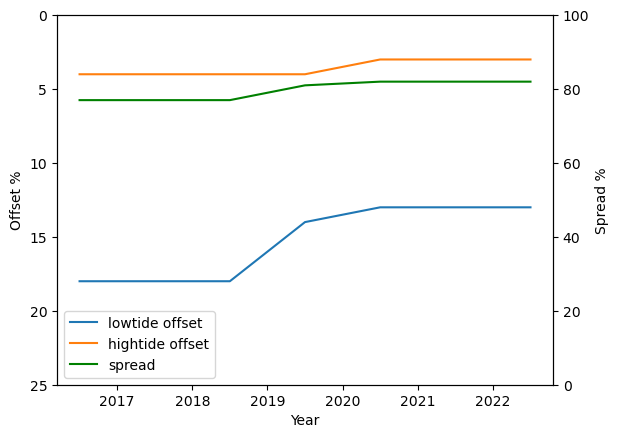

In [139]:
# Set the figure and secondary axis
fig, ax = plt.subplots()
ax2=ax.twinx()

# Plot the data
ax2.plot(ds.time,ds.ta_spread.mean(dim=['x','y']), label='spread', color='g')
ax.plot(ds.time,ds.ta_offset_low.mean(dim=['x','y']), label='lowtide offset')
ax.plot(ds.time,ds.ta_offset_high.mean(dim=['x','y']), label='hightide offset')

# Set the y-axis values and labels
ax.set_ylim(0,25)
ax.set_ylabel('Offset %')
ax.invert_yaxis()
ax2.set_ylim(0,100)
ax2.set_ylabel('Spread %')
ax.set_xlabel('Year')

# Set the legend
h,l=ax.get_legend_handles_labels()
h1,l1 = ax2.get_legend_handles_labels()

handles = h + h1
labels = l + l1

ax.legend(handles, labels)


- animate and view rgb and exposure
- compare against spread and bias offsets
- maybe say something from https://seamapaustralia.org/map/

Rationale/Purpose - Show users how they might use some of these datasets together (using the loaded ds), interpret the results and export the data (assuming they're more likely to be GIS users and want to consider this information relative to other datasets in their area of interest).
**Question:** Should we build this in a separate notebook and link to it at the bottom of this one? (This notebook is already unusually long for a dea-notebook).

Proposal
- users choose a small aoi
- load the full product suite


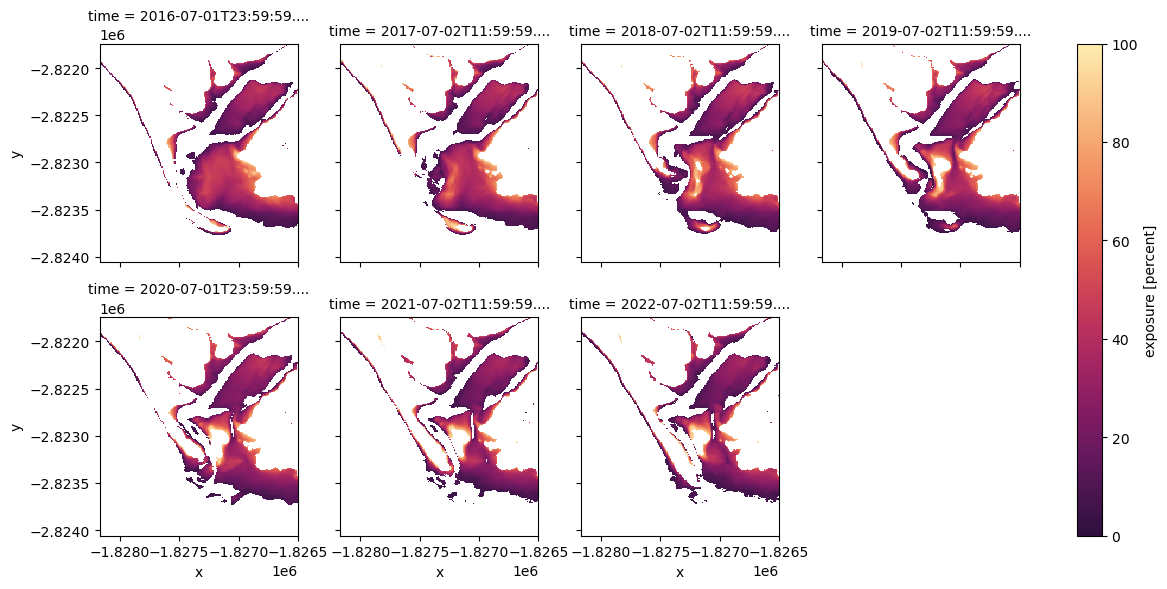

In [23]:
ds['exposure'].plot(col='time', col_wrap=4, cmap=cmocean.cm.matter_r, vmin=0, vmax=100)
# ds.exposure.plot

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2024

**Compatible datacube version:** 

In [24]:
print(datacube.__version__)

1.8.17


## Tags - TODO
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)